# Installing and importing packages


In [ ]:
!pip install -qU svgwrite ndjson torch

In [ ]:
import requests
import ndjson
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import time
import svgwrite
from IPython.display import SVG, display, clear_output
from tqdm import trange

# Setting pre-train parameters and user-controlled knobs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/simplified/axe.ndjson'
max_doodle_len = 7
max_stroke_len = 1
max_gen_len = 1

batch_size = 50
lr = 0.001
num_epochs = 5
hidden_size = 512
latent_size = 512
num_layers = 6
num_heads = 8
ff_dim = 2048
dropout = 0

# Util functions for data pre-processing

In [ ]:
def load_data():
    response = requests.get(dataset_url)
    data = ndjson.loads(response.text)
    return data

In [ ]:
def extract_useful_doodles(data):
    useful_doodles = []
    for doodle in data:
        if doodle['recognized']:
            useful_doodles.append(doodle['drawing'])
    return useful_doodles

In [ ]:
def zip_strokes(data):
    new_data = []
    for doodle in data:
        new_data.append([[list(x) for x in zip(stroke[0], stroke[1])] for stroke in doodle])
    return new_data

In [ ]:
def pad_all_doodles(data):
    global max_stroke_len
    for doodle in data:
        max_stroke_len = max(
            max_stroke_len,
            max([len(stroke) for stroke in doodle])
        )

    new_data = []
    for doodle in data:
        new_doodle = []
        for stroke in doodle:
            new_stroke = np.pad(
                stroke,
                ((max_stroke_len - len(stroke), 0), (0, 0)),
                mode='constant',
                constant_values=0
            )
            new_doodle.append(new_stroke)
        new_data.append(np.array(new_doodle))

    for index, doodle in enumerate(new_data):
        if max_doodle_len <= doodle.shape[0]:
            new_data[index] = doodle[doodle.shape[0] - max_doodle_len:]
        else:
            new_data[index] = np.pad(
                doodle,
                ((max_doodle_len - doodle.shape[0], 0), (max_stroke_len - doodle.shape[1], 0), (2 - doodle.shape[2], 0))
            )

    new_data = np.array(new_data)
    new_data = new_data.reshape(new_data.shape[0], new_data.shape[1], -1)

    return new_data

# Util functions for visualizations

In [ ]:
def draw_strokes_real_time(strokes):
    strokes = np.flip(strokes, axis=1)

    dwg = svgwrite.Drawing(size=(255, 255))
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), fill='white'))
    display(SVG(dwg.tostring()))

    idx = 2
    for stroke in strokes:
        polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="black", fill="none", stroke_width=2)

        dwg.add(polyline)

        points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
        for point in points:
            if point == (0, 0): continue
            #print(point)
            polyline.points.append(point)
            display(SVG(dwg.tostring()))
            time.sleep(0.03)
            clear_output(wait=True)

In [ ]:
def draw_strokes_real_time_for_viz(strokes):
    strokes = np.flip(strokes, axis=1)

    dwg = svgwrite.Drawing(size=(255, 255))
    dwg.add(dwg.rect(insert=(0, 0), size=('100%', '100%'), fill='white'))
    display(SVG(dwg.tostring()))

    idx = 2
    for stroke in strokes[:-1]:
        polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="black", fill="none", stroke_width=2)

        dwg.add(polyline)

        points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
        for point in points:
            if point == (0, 0): continue
            #print(point)
            polyline.points.append(point)
            display(SVG(dwg.tostring()))
            time.sleep(0.03)
            clear_output(wait=True)

    stroke = strokes[-1]
    polyline = dwg.polyline([(int(stroke[idx-2]), int(stroke[idx-1]))], stroke="red", fill="none", stroke_width=2)

    dwg.add(polyline)

    points = [(int(stroke[i*idx]), int(stroke[i*idx+1])) for i in range(1, len(stroke)//2)]
    # print(points)
    for point in points:
        if any(value < 25 for value in point): continue
        #print(point)
        polyline.points.append(point)
        display(SVG(dwg.tostring()))
        time.sleep(0.03)
        clear_output(wait=True)

# Import, process and test our dataset

In [ ]:
dataset = load_data()

In [ ]:
doodles = extract_useful_doodles(dataset)

In [ ]:
doodles = zip_strokes(doodles)

# Sanity check
assert np.allclose(
    np.array([list(x) for x in zip(dataset[0]['drawing'][0][0], dataset[0]['drawing'][0][1])]),
    doodles[0][0]
)

In [ ]:
doodles = pad_all_doodles(doodles)

# Sanity check
assert type(doodles[0]) == type(np.array([[]]))

In [ ]:
display(doodles.shape)

(115536, 5, 384)

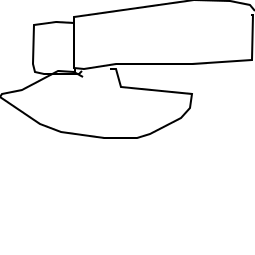

In [ ]:
for i in np.random.randint(0, len(doodles), size=10):
    draw_strokes_real_time(doodles[i])
    time.sleep(0.5)

# Train test val split

In [ ]:
class DoodleDataset(Dataset):
    def __init__(self, doodles):
        self.doodles = doodles

    def __len__(self):
        return len(self.doodles)

    def __getitem__(self, idx):
        # Get a single doodle from the array
        doodle = self.doodles[idx]
        return doodle

In [ ]:
doodles = torch.tensor(doodles)
train_data, test_data = train_test_split(doodles, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("train data:", len(train_data))
print("test data:", len(test_data))
print("val data:", len(val_data))

train data: 83185
test data: 11554
val data: 20797


In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)

# Define the transformer-based encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        # print("Encoder input shape", x.shape)
        _, (h, _) = self.rnn(x)
        latent_representation = self.fc(h.squeeze(0))
        # print("Encoder latent state shape", latent_representation.shape)
        return latent_representation

# Define the transformer-based decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # print("Decoder input shape", x.shape)
        output, _ = self.rnn(x, hidden)
        output = self.fc(output)
        # print("Decoder output shape", output.shape)
        return output

# Use the encoder and decoder in a model

In [ ]:
class SketchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(SketchRNN, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)

    def forward(self, x):
        latent_representation = self.encoder(x)
        # Replicate latent representation to match batch size of input data
        latent_representation = latent_representation.unsqueeze(1).repeat(1, x.size(1), 1)
        output = self.decoder(latent_representation, None)
        return output

# Define the training function

In [ ]:
def train_model(model, train_loader, criterion, optimizer, val_loader):
    losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Inside the training loop
        data_loader_iter = iter(train_loader)
        total_batches = len(train_loader)

        for _ in trange(total_batches):
            strokes = next(data_loader_iter)  # Extract strokes
            optimizer.zero_grad()

            strokes = strokes.float()  # Convert to float
            # print("Input data shape", strokes.shape)

            # Obtain output from the model using input data (strokes)
            output = model(strokes)

            # Reshape output tensor to match the shape of strokes tensor
            output = output.view(strokes.shape[0], -1, output.size(2))
            # print("Output shape", output.shape)

            # Flatten the strokes tensor for the loss calculation
            strokes_flat = strokes.view(-1, strokes.size(-1))  # This flattens while preserving the batch size

            # Ensure strokes_flat has the same batch size as the output tensor
            strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
            strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
            # print("Target shape", strokes_flat.shape)

            # Calculate loss and update model parameters
            loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0.0
        data_loader_iter = iter(train_loader)
        total_batches = len(train_loader)
        with torch.no_grad():  # Disable gradient tracking for validation
            for _ in trange(total_batches):
                strokes = next(data_loader_iter)  # Extract strokes
                strokes = strokes.float()
                output = model(strokes)
                output = output.view(strokes.shape[0], -1, output.size(2))
                strokes_flat = strokes.view(-1, strokes.size(-1))
                strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
                strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
                loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
                total_val_loss += loss.item()

        loss = total_loss / len(train_loader)
        losses.append(loss)
        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss}, Validation Loss: {val_loss}\n")

    torch.save(model.state_dict(), 'model.pth')
    return losses, val_losses

# Train the model

In [ ]:
num_epochs = 100
input_size  = doodles.shape[-1]
output_size = doodles.shape[-1]

model = SketchRNN(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

losses, val_losses = train_model(model, train_loader, criterion, optimizer, val_loader)

  0%|          | 0/1663 [00:00<?, ?it/s]

100%|██████████| 1663/1663 [00:45<00:00, 36.30it/s]


Epoch 1/100, Train Loss: 180.6604207050922, Validation Loss: 509.84854835602175



100%|██████████| 1663/1663 [00:45<00:00, 36.25it/s]


Epoch 2/100, Train Loss: 101.99711455427159, Validation Loss: 319.2673441875412



100%|██████████| 1663/1663 [00:46<00:00, 36.12it/s]


Epoch 3/100, Train Loss: 66.81821055134161, Validation Loss: 226.09111859425005



100%|██████████| 1663/1663 [00:46<00:00, 35.75it/s]


Epoch 4/100, Train Loss: 51.27225538426971, Validation Loss: 184.74236558661403



100%|██████████| 1663/1663 [00:45<00:00, 36.26it/s]


Epoch 5/100, Train Loss: 43.238747591579525, Validation Loss: 162.28355956020124



100%|██████████| 1663/1663 [00:46<00:00, 36.09it/s]


Epoch 6/100, Train Loss: 38.34577587033637, Validation Loss: 147.67795086596385



100%|██████████| 1663/1663 [00:46<00:00, 36.04it/s]


Epoch 7/100, Train Loss: 34.98332252204239, Validation Loss: 134.08841207573212



100%|██████████| 1663/1663 [00:45<00:00, 36.16it/s]


Epoch 8/100, Train Loss: 32.39671774707641, Validation Loss: 123.95790118941342



100%|██████████| 1663/1663 [00:46<00:00, 36.09it/s]


Epoch 9/100, Train Loss: 30.305883643860856, Validation Loss: 114.35007911130606



100%|██████████| 1663/1663 [00:47<00:00, 35.29it/s]


Epoch 10/100, Train Loss: 28.789142832294402, Validation Loss: 112.77376727368458



100%|██████████| 1663/1663 [00:46<00:00, 35.91it/s]


Epoch 11/100, Train Loss: 27.37556075132259, Validation Loss: 108.8275953591588



100%|██████████| 1663/1663 [00:45<00:00, 36.39it/s]


Epoch 12/100, Train Loss: 26.270456654725844, Validation Loss: 102.11933218944503



100%|██████████| 1663/1663 [00:46<00:00, 36.15it/s]


Epoch 13/100, Train Loss: 25.246535386081497, Validation Loss: 97.60364950478795



100%|██████████| 1663/1663 [00:45<00:00, 36.44it/s]


Epoch 14/100, Train Loss: 24.352554936044847, Validation Loss: 93.87132263413395



100%|██████████| 1663/1663 [00:45<00:00, 36.60it/s]


Epoch 15/100, Train Loss: 23.58588795251898, Validation Loss: 93.46111933926503



100%|██████████| 1663/1663 [00:46<00:00, 36.12it/s]


Epoch 16/100, Train Loss: 22.940140923174905, Validation Loss: 90.78684216005256



100%|██████████| 1663/1663 [00:45<00:00, 36.53it/s]


Epoch 17/100, Train Loss: 22.338081201586604, Validation Loss: 88.63921339655496



100%|██████████| 1663/1663 [00:45<00:00, 36.58it/s]


Epoch 18/100, Train Loss: 21.84042555613469, Validation Loss: 83.79115953330535



100%|██████████| 1663/1663 [00:45<00:00, 36.19it/s]


Epoch 19/100, Train Loss: 21.242256617589092, Validation Loss: 82.66694220807179



100%|██████████| 1663/1663 [00:45<00:00, 36.79it/s]


Epoch 20/100, Train Loss: 20.75473000267795, Validation Loss: 81.01825439269284



100%|██████████| 1663/1663 [00:46<00:00, 35.71it/s]


Epoch 21/100, Train Loss: 20.270263627144637, Validation Loss: 78.82467081230807



100%|██████████| 1663/1663 [00:45<00:00, 36.45it/s]


Epoch 22/100, Train Loss: 19.722834875550674, Validation Loss: 76.40061551748988



100%|██████████| 1663/1663 [00:45<00:00, 36.85it/s]


Epoch 23/100, Train Loss: 19.429228483304446, Validation Loss: 75.5936685814915



100%|██████████| 1663/1663 [00:45<00:00, 36.55it/s]


Epoch 24/100, Train Loss: 19.15456836824308, Validation Loss: 77.29253172817



100%|██████████| 1663/1663 [00:45<00:00, 36.66it/s]


Epoch 25/100, Train Loss: 18.887748428087814, Validation Loss: 73.81034594156655



100%|██████████| 1663/1663 [00:45<00:00, 36.43it/s]


Epoch 26/100, Train Loss: 18.452186160681123, Validation Loss: 71.96523650295764



100%|██████████| 1663/1663 [00:45<00:00, 36.42it/s]


Epoch 27/100, Train Loss: 18.06728559334595, Validation Loss: 70.8377110860434



100%|██████████| 1663/1663 [00:55<00:00, 29.99it/s]


Epoch 28/100, Train Loss: 17.839527259730318, Validation Loss: 69.97053851391895



100%|██████████| 1663/1663 [00:50<00:00, 32.70it/s]


Epoch 29/100, Train Loss: 17.511838625083826, Validation Loss: 68.23220258505948



100%|██████████| 1663/1663 [00:52<00:00, 31.60it/s]


Epoch 30/100, Train Loss: 17.36212476878301, Validation Loss: 67.35827600180384



100%|██████████| 1663/1663 [00:51<00:00, 32.38it/s]


Epoch 31/100, Train Loss: 16.979089492068404, Validation Loss: 67.09419286796846



100%|██████████| 1663/1663 [00:50<00:00, 32.73it/s]


Epoch 32/100, Train Loss: 16.888127528251974, Validation Loss: 65.13968968448869



100%|██████████| 1663/1663 [00:51<00:00, 32.32it/s]


Epoch 33/100, Train Loss: 16.769369386293338, Validation Loss: 66.7572154240436



100%|██████████| 1663/1663 [00:50<00:00, 32.79it/s]


Epoch 34/100, Train Loss: 16.35096348930538, Validation Loss: 63.58947068409747



100%|██████████| 1663/1663 [00:50<00:00, 32.66it/s]


Epoch 35/100, Train Loss: 16.162839198499576, Validation Loss: 64.90485728620047



100%|██████████| 1663/1663 [00:51<00:00, 32.49it/s]


Epoch 36/100, Train Loss: 16.110128351098002, Validation Loss: 62.67322509949466



100%|██████████| 1663/1663 [00:50<00:00, 32.69it/s]


Epoch 37/100, Train Loss: 15.836048902120492, Validation Loss: 62.3951061179839



100%|██████████| 1663/1663 [00:45<00:00, 36.88it/s]


Epoch 38/100, Train Loss: 15.779611655193428, Validation Loss: 63.128024085171255



100%|██████████| 1663/1663 [00:45<00:00, 36.66it/s]


Epoch 39/100, Train Loss: 15.71853530342437, Validation Loss: 61.0759369034365



100%|██████████| 1663/1663 [00:45<00:00, 36.28it/s]


Epoch 40/100, Train Loss: 15.45151561695771, Validation Loss: 60.080264174220076



100%|██████████| 1663/1663 [00:46<00:00, 35.96it/s]


Epoch 41/100, Train Loss: 15.38090641471326, Validation Loss: 59.92290055378374



100%|██████████| 1663/1663 [00:45<00:00, 36.45it/s]


Epoch 42/100, Train Loss: 15.210509006043765, Validation Loss: 60.04304628716894



100%|██████████| 1663/1663 [00:45<00:00, 36.16it/s]


Epoch 43/100, Train Loss: 15.124249509924947, Validation Loss: 60.17291664675058



100%|██████████| 1663/1663 [00:45<00:00, 36.45it/s]


Epoch 44/100, Train Loss: 14.934948173403669, Validation Loss: 59.00644084057176



100%|██████████| 1663/1663 [00:45<00:00, 36.71it/s]


Epoch 45/100, Train Loss: 14.811243921464563, Validation Loss: 58.726984899589816



100%|██████████| 1663/1663 [00:45<00:00, 36.64it/s]


Epoch 46/100, Train Loss: 14.704225934132422, Validation Loss: 56.86464149521058



100%|██████████| 1663/1663 [00:45<00:00, 36.85it/s]


Epoch 47/100, Train Loss: 14.5510894998469, Validation Loss: 57.960973456968745



100%|██████████| 1663/1663 [00:45<00:00, 36.62it/s]


Epoch 48/100, Train Loss: 14.326480014454651, Validation Loss: 55.631774865575586



100%|██████████| 1663/1663 [00:45<00:00, 36.53it/s]


Epoch 49/100, Train Loss: 14.316845449997013, Validation Loss: 55.77097551047084



100%|██████████| 1663/1663 [00:46<00:00, 36.09it/s]


Epoch 50/100, Train Loss: 14.139732427361924, Validation Loss: 56.40322855983872



100%|██████████| 1663/1663 [00:46<00:00, 35.67it/s]


Epoch 51/100, Train Loss: 14.221779808393102, Validation Loss: 54.70994475031473



100%|██████████| 1663/1663 [00:46<00:00, 36.15it/s]


Epoch 52/100, Train Loss: 14.019044876098633, Validation Loss: 56.02145108142531



100%|██████████| 1663/1663 [00:48<00:00, 34.19it/s]


Epoch 53/100, Train Loss: 13.814944680168624, Validation Loss: 54.38441493367574



100%|██████████| 1663/1663 [00:47<00:00, 34.90it/s]


Epoch 54/100, Train Loss: 13.813929464038567, Validation Loss: 54.1951963286802



100%|██████████| 1663/1663 [00:46<00:00, 35.87it/s]


Epoch 55/100, Train Loss: 13.800796755379535, Validation Loss: 55.50582758777113



100%|██████████| 1663/1663 [00:47<00:00, 35.34it/s]


Epoch 56/100, Train Loss: 13.687693851078697, Validation Loss: 53.39423950608954



100%|██████████| 1663/1663 [00:47<00:00, 35.25it/s]


Epoch 57/100, Train Loss: 13.537837838237714, Validation Loss: 53.422042523809225



100%|██████████| 1663/1663 [00:46<00:00, 36.15it/s]


Epoch 58/100, Train Loss: 13.476441508950918, Validation Loss: 52.71368178402085



100%|██████████| 1663/1663 [00:46<00:00, 36.13it/s]


Epoch 59/100, Train Loss: 13.398227262984394, Validation Loss: 53.093700069979015



100%|██████████| 1663/1663 [00:46<00:00, 36.05it/s]


Epoch 60/100, Train Loss: 13.391340837518781, Validation Loss: 52.87711954231722



100%|██████████| 1663/1663 [00:46<00:00, 35.88it/s]


Epoch 61/100, Train Loss: 13.246542626092467, Validation Loss: 52.06694463706878



100%|██████████| 1663/1663 [00:46<00:00, 36.13it/s]


Epoch 62/100, Train Loss: 13.140571432520808, Validation Loss: 52.89258711481669



100%|██████████| 1663/1663 [00:46<00:00, 35.91it/s]


Epoch 63/100, Train Loss: 13.250090847657663, Validation Loss: 50.91539792784725



100%|██████████| 1663/1663 [00:46<00:00, 36.06it/s]


Epoch 64/100, Train Loss: 13.12750681465961, Validation Loss: 51.217460573724956



100%|██████████| 1663/1663 [00:45<00:00, 36.20it/s]


Epoch 65/100, Train Loss: 13.184083158111113, Validation Loss: 53.279103130892096



100%|██████████| 1663/1663 [00:45<00:00, 36.39it/s]


Epoch 66/100, Train Loss: 13.063873727710147, Validation Loss: 51.5271809589432



100%|██████████| 1663/1663 [00:45<00:00, 36.16it/s]


Epoch 67/100, Train Loss: 12.948802019269511, Validation Loss: 52.09053369545075



100%|██████████| 1663/1663 [00:46<00:00, 36.09it/s]


Epoch 68/100, Train Loss: 12.922282253054345, Validation Loss: 50.755823802948



100%|██████████| 1663/1663 [00:46<00:00, 36.06it/s]


Epoch 69/100, Train Loss: 12.82543118259524, Validation Loss: 49.47033033715673



100%|██████████| 1663/1663 [00:46<00:00, 36.03it/s]


Epoch 70/100, Train Loss: 12.836176029831547, Validation Loss: 50.48129062192986



100%|██████████| 1663/1663 [00:46<00:00, 35.99it/s]


Epoch 71/100, Train Loss: 12.7232862611313, Validation Loss: 49.62117415738393



100%|██████████| 1663/1663 [00:46<00:00, 36.11it/s]


Epoch 72/100, Train Loss: 12.749580579139494, Validation Loss: 50.3049869859075



100%|██████████| 1663/1663 [00:48<00:00, 34.15it/s]


Epoch 73/100, Train Loss: 12.583903272827204, Validation Loss: 49.23602385118783



100%|██████████| 1663/1663 [00:47<00:00, 35.24it/s]


Epoch 74/100, Train Loss: 12.649968345697143, Validation Loss: 50.36940214777567



100%|██████████| 1663/1663 [00:47<00:00, 35.10it/s]


Epoch 75/100, Train Loss: 12.594991758510568, Validation Loss: 49.00743693730917



100%|██████████| 1663/1663 [00:47<00:00, 35.15it/s]


Epoch 76/100, Train Loss: 12.59161605479412, Validation Loss: 48.79239355454962



100%|██████████| 1663/1663 [00:47<00:00, 34.97it/s]


Epoch 77/100, Train Loss: 12.409599129292022, Validation Loss: 50.78536960532866



100%|██████████| 1663/1663 [00:45<00:00, 36.19it/s]


Epoch 78/100, Train Loss: 12.363550993597658, Validation Loss: 48.24924726486206



100%|██████████| 1663/1663 [00:47<00:00, 35.29it/s]


Epoch 79/100, Train Loss: 12.330179610169228, Validation Loss: 48.0112882889897



100%|██████████| 1663/1663 [00:46<00:00, 35.75it/s]


Epoch 80/100, Train Loss: 12.37914023425159, Validation Loss: 49.415369949570625



100%|██████████| 1663/1663 [00:47<00:00, 35.22it/s]


Epoch 81/100, Train Loss: 12.194997221751164, Validation Loss: 47.70134280446064



100%|██████████| 1663/1663 [00:46<00:00, 35.60it/s]


Epoch 82/100, Train Loss: 12.27261069705525, Validation Loss: 48.08039584217301



100%|██████████| 1663/1663 [00:47<00:00, 35.36it/s]


Epoch 83/100, Train Loss: 12.120208069278902, Validation Loss: 47.44194419010576



100%|██████████| 1663/1663 [00:47<00:00, 34.77it/s]


Epoch 84/100, Train Loss: 12.158947635542823, Validation Loss: 48.347334915758616



100%|██████████| 1663/1663 [00:47<00:00, 35.08it/s]


Epoch 85/100, Train Loss: 12.146671310936336, Validation Loss: 48.038493556286916



100%|██████████| 1663/1663 [00:47<00:00, 35.12it/s]


Epoch 86/100, Train Loss: 12.07024621217995, Validation Loss: 47.654994961152596



100%|██████████| 1663/1663 [00:47<00:00, 35.24it/s]


Epoch 87/100, Train Loss: 12.067035502435496, Validation Loss: 47.880559708698684



100%|██████████| 1663/1663 [00:47<00:00, 35.37it/s]


Epoch 88/100, Train Loss: 12.034695374413706, Validation Loss: 48.27812049934663



100%|██████████| 1663/1663 [00:48<00:00, 34.25it/s]


Epoch 89/100, Train Loss: 11.923036720404335, Validation Loss: 46.253840684316245



100%|██████████| 1663/1663 [00:48<00:00, 34.09it/s]


Epoch 90/100, Train Loss: 11.95214072696, Validation Loss: 46.496137471945886



100%|██████████| 1663/1663 [00:48<00:00, 33.96it/s]


Epoch 91/100, Train Loss: 11.839560873452541, Validation Loss: 46.76613307171557



100%|██████████| 1663/1663 [00:49<00:00, 33.29it/s]


Epoch 92/100, Train Loss: 11.845477047127122, Validation Loss: 45.96881706628455



100%|██████████| 1663/1663 [00:49<00:00, 33.80it/s]


Epoch 93/100, Train Loss: 11.80812455628625, Validation Loss: 46.442198939495775



100%|██████████| 1663/1663 [00:49<00:00, 33.77it/s]


Epoch 94/100, Train Loss: 11.72934013895435, Validation Loss: 46.73461963239922



100%|██████████| 1663/1663 [00:54<00:00, 30.70it/s]


Epoch 95/100, Train Loss: 11.794249015620009, Validation Loss: 46.29083217597869



100%|██████████| 1663/1663 [00:48<00:00, 34.52it/s]


Epoch 96/100, Train Loss: 11.876599094484918, Validation Loss: 47.04777905222881



100%|██████████| 1663/1663 [00:49<00:00, 33.73it/s]


Epoch 97/100, Train Loss: 11.6789784660844, Validation Loss: 46.90684071736163



100%|██████████| 1663/1663 [00:48<00:00, 34.20it/s]


Epoch 98/100, Train Loss: 11.721457321387204, Validation Loss: 45.08804674033659



100%|██████████| 1663/1663 [00:51<00:00, 32.06it/s]


Epoch 99/100, Train Loss: 11.52267401575397, Validation Loss: 46.26997448794813



100%|██████████| 1663/1663 [00:49<00:00, 33.50it/s]

Epoch 100/100, Train Loss: 11.666727972403393, Validation Loss: 45.43831401847931



# Set the models to eval, and run tests

In [ ]:
def test_model(model, test_loader, criterion):
    # Test
    model.eval()  # Set model to evaluation mode

    total_test_loss = 0.0
    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in test_loader:
            strokes = batch.float()
            output = model(strokes)
            output = output.view(strokes.shape[0], -1, output.size(2))
            strokes_flat = strokes.view(-1, strokes.size(-1))
            strokes_flat = strokes_flat[:, :output.size(1) * output.size(2)]  # Adjust sequence length
            strokes_flat = strokes_flat.view(strokes.shape[0], -1, strokes.size(-1))
            loss = criterion(output.view(-1, output.size(2)), strokes_flat.view(-1, strokes_flat.size(-1)))
            total_test_loss += loss.item()

    test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {test_loss}\n")
    return test_loss

In [ ]:
test_loss = test_model(model, test_loader, criterion)

Test Loss: 12.803614023959998



# Plots to visualize the training process

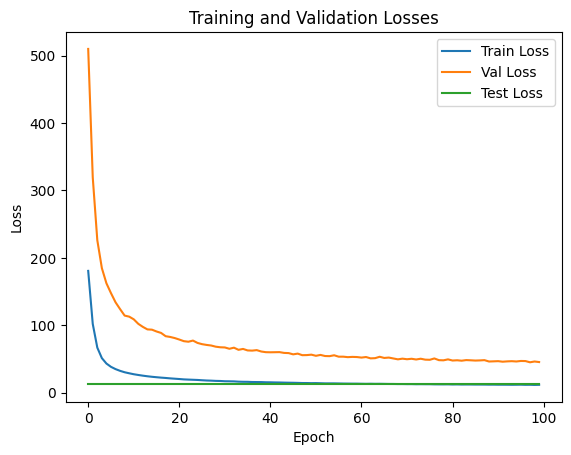

In [ ]:
# Plot the losses
import matplotlib.pyplot as plt

plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.plot([test_loss]*num_epochs, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# An Example

In [ ]:
import io

input_size  = doodles.shape[-1]
output_size = doodles.shape[-1]

model = SketchRNN(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, output_size=output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model_path = "axe.pth"

buffer = io.BytesIO()
torch.save(torch.load(model_path, map_location=torch.device('cpu')), buffer)
buffer.seek(0)

model.load_state_dict(torch.load(buffer))

<All keys matched successfully>

In [ ]:
def test_model_with_output(model, test_loader):
    # Test
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient tracking for validation
        for batch in test_loader:
            strokes = batch.float()
            output = model(strokes)
            output = output.view(strokes.shape[0], -1, output.size(2))

            img = strokes[0, :max_doodle_len-1]
            pred = output[0, max_doodle_len-1].reshape(1, -1)
            viz = torch.floor(torch.cat([img, pred])).numpy()
            viz[viz < 0] = 0
            draw_strokes_real_time_for_viz(viz)
            # print(viz[-1])
            break


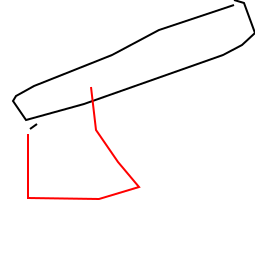

In [ ]:
test_model_with_output(model, test_loader)

In [ ]:
print(model)

SketchRNN(
  (encoder): Encoder(
    (rnn): LSTM(384, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (rnn): LSTM(512, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=384, bias=True)
  )
)
